# Isolation Forest – Anomaly Detection

This notebook demonstrates **unsupervised anomaly detection** using the
`IsolationForest` implementation from `AILibs`.

**Key idea:** Anomalies are *few and different*, so they are isolated
quickly in random binary trees (shorter average path length → higher
anomaly score).

We use the **Credit Card Fraud** dataset where the last column contains
a binary fraud label (0 = normal, 1 = fraud). The label is **not** used
during training – only for evaluation.

> Liu, F. T., Ting, K. M., & Zhou, Z.-H. (2008). *Isolation Forest.* ICDM.

In [1]:
import numpy
import matplotlib.pyplot as plt
import AILibs

## 1 · Load the dataset

The CSV is loaded with `AILibs.datasets.CSVDataset`. All numeric columns
are kept; the last column is the fraud indicator.

In [2]:
file_name = "/Users/michal/datasets/creditcard/creditcard.csv"
dataset   = AILibs.datasets.CSVDataset(file_name)

print("Dataset shape:", dataset.x.shape)
print("Total samples:", dataset.x.shape[0])
print("Features     :", dataset.x.shape[1] - 1, "(last column is the label)")

Dataset shape: (284807, 31)
Total samples: 284807
Features     : 30 (last column is the label)


## 2 · Train / Test split

We randomly shuffle the data and split 80 % for training, 20 % for
testing. The fraud label (`y_gt`) is separated from the features and
is only used later for evaluation.

In [3]:
# Reproducible shuffle
numpy.random.seed(42)

test_ratio = 0.2
indices    = numpy.arange(dataset.x.shape[0])
numpy.random.shuffle(indices)

split_idx      = int((1 - test_ratio) * dataset.x.shape[0])
train_indices  = indices[:split_idx]
test_indices   = indices[split_idx:]

# Features only (exclude last column = label)
x_train = dataset.x[train_indices, :-1]
x_test  = dataset.x[test_indices,  :-1]

# Ground-truth labels (for evaluation only)
y_gt = dataset.x[test_indices, -1]

print(f"Train set : {x_train.shape}")
print(f"Test  set : {x_test.shape}")
print(f"Fraud rate (test): {y_gt.mean():.4f}")

Train set : (227845, 30)
Test  set : (56962, 30)
Fraud rate (test): 0.0018


## 3 · Fit the Isolation Forest

The forest is trained **without labels** – it only learns the structure
of the feature space. Key hyper-parameters:

| Parameter        | Value | Description |
|------------------|------:|-------------|
| `max_depth`      |    12 | Maximum tree depth |
| `num_trees`      |   128 | Number of isolation trees |
| `num_subsamples` |  4096 | Subsample size per tree (speeds up training) |

In [4]:
forest = AILibs.forest.IsolationForest()
forest.fit(x_train, max_depth=12, num_trees=128, num_subsamples=4096)

print("Isolation Forest fitted with", len(forest.forest), "trees")

Isolation Forest fitted with 128 trees


## 4 · Predict anomaly scores

Each test sample receives a score in (0, 1].  
- Scores **close to 1** → likely anomaly  
- Scores **close to 0.5** → normal

In [5]:
scores = forest.predict(x_test)

print(f"Score range : [{scores.min():.4f}, {scores.max():.4f}]")
print(f"Score mean  : {scores.mean():.4f}")
print(f"Score std   : {scores.std():.4f}")

Score range : [0.7053, 0.8759]
Score mean  : 0.7070
Score std   : 0.0066


## 5 · Score distribution

Plotting the anomaly-score histograms for normal vs. fraudulent
transactions shows how well the forest separates the two classes.

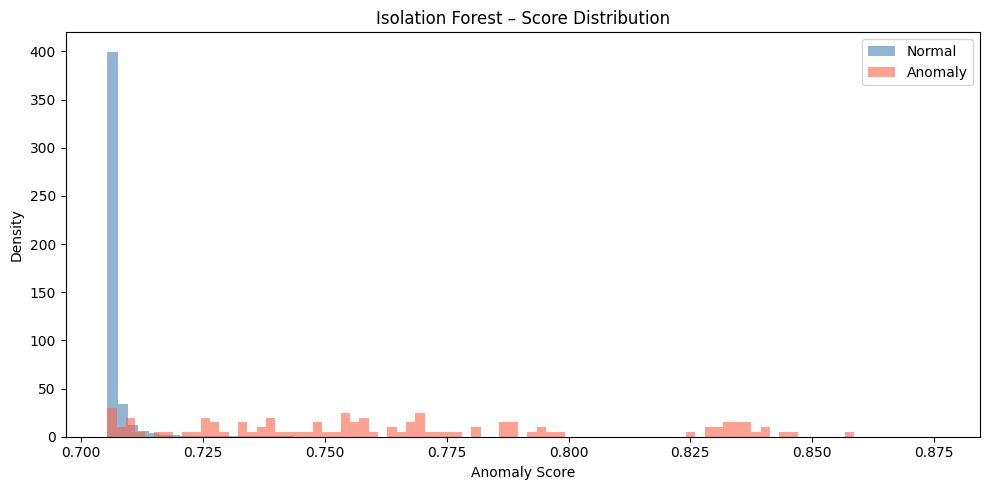

In [6]:
normal_mask  = y_gt < 0.5
anomaly_mask = y_gt >= 0.5

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(scores[normal_mask],  bins=80, alpha=0.6, label="Normal",  color="steelblue", density=True)
ax.hist(scores[anomaly_mask], bins=80, alpha=0.6, label="Anomaly", color="tomato",    density=True)
ax.set_xlabel("Anomaly Score")
ax.set_ylabel("Density")
ax.set_title("Isolation Forest – Score Distribution")
ax.legend()
plt.tight_layout()
plt.show()

## 6 · Tune the decision threshold

Because the anomaly score is continuous we need a threshold to convert
it into a binary prediction. `tune_threshold` sweeps thresholds from
0 to 1 and picks the one that maximises the chosen metric (F1 by default).

In [7]:
th = AILibs.metrics.tune_threshold(y_gt, scores, metric="f1")
print(f"Optimal threshold (F1): {th}")

Optimal threshold (F1): 0.76768


## 7 · Full evaluation

`anomaly_evaluation` returns both threshold-independent metrics
(AUC-ROC, AUC-PR) and threshold-dependent metrics (precision, recall,
F1, MCC, confusion matrix, …).

In [8]:
metrics = AILibs.metrics.anomaly_evaluation(y_gt, scores, th=th)
print(AILibs.metrics.format_metrics(metrics))

n_samples: 56962
n_anomalies: 105
n_normal: 56857
anomaly_ratio: 0.00184
auc_roc: 0.95113
auc_pr: 0.25576
score_mean: 0.70703
score_std: 0.00664
score_mean_normal: 0.70692
score_mean_anomaly: 0.76514
score_separation: 0.05822
threshold: 0.76768
accuracy: 0.99691
precision: 0.27389
recall: 0.40952
specificity: 0.99799
f1_score: 0.32824
mcc: 0.33342
balanced_accuracy: 0.70376
iou: 0.19635
dice: 0.32824
fpr: 0.00201
fnr: 0.59048
tp: 43
tn: 56743
fp: 114
fn: 62


## 8 · Confusion matrix heatmap

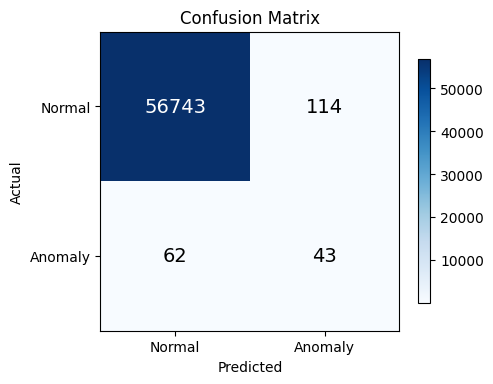

In [9]:
cm = numpy.array([[metrics["tn"], metrics["fp"]],
                  [metrics["fn"], metrics["tp"]]])

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")

# Annotate each cell
for i in range(2):
    for j in range(2):
        ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                fontsize=14, color="white" if cm[i, j] > cm.max() / 2 else "black")

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Normal", "Anomaly"])
ax.set_yticklabels(["Normal", "Anomaly"])
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

## 9 · Key metrics bar chart

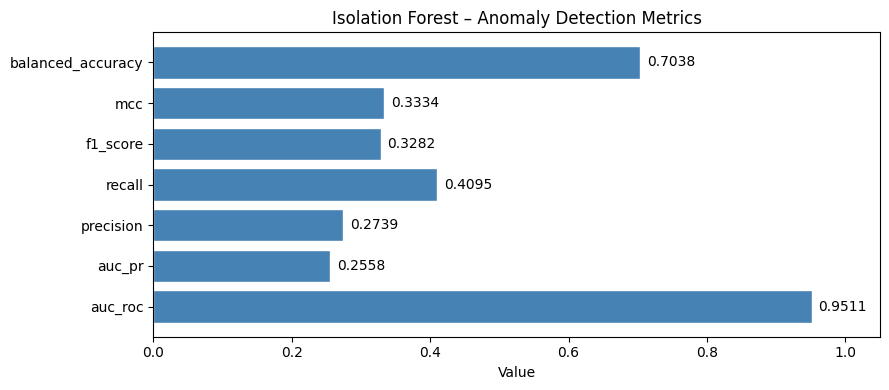

In [10]:
metric_names  = ["auc_roc", "auc_pr", "precision", "recall", "f1_score", "mcc", "balanced_accuracy"]
metric_values = [metrics[m] for m in metric_names]

fig, ax = plt.subplots(figsize=(9, 4))
bars = ax.barh(metric_names, metric_values, color="steelblue", edgecolor="white")
ax.set_xlim(0, 1.05)
ax.set_xlabel("Value")
ax.set_title("Isolation Forest – Anomaly Detection Metrics")

# Value labels
for bar, val in zip(bars, metric_values):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
            f"{val:.4f}", va="center", fontsize=10)

plt.tight_layout()
plt.show()